In [1]:
# coding: utf-8
import sys
from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt

import os

from matplotlib import colors
import matplotlib.pyplot as plt

# from cupyx.scipy.signal import convolve2d as conv2
# import cupy as cp

# from scipy.signal import convolve2d as conv2np
import random

from multiprocessing import Pool, get_context
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from joblib import Parallel, delayed

from pathlib import Path

import h5py

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../'))) #add deconvolutionNN directory to path in order to import other files
from src.utils.preprocessing_functions import *

In [2]:
plt.rcParams["image.cmap"] = "jet"

#reduce size of diffraction patterns
red=True

#save model pth
save=True

# Setting path
path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
#path=Path('/mnt/micdata2/12IDC/ptychosaxs') # micdata location 1 (refiner)
#path=Path('/net/micdata/data2/12IDC/ptychosaxs') # micdata location 2 (refiner and artemis)

# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

Y:\ptychosaxs\trained_model


In [3]:
# Parameters
num = 13# 13, scanned with 400, subtracted out probe; 12, scanned with 400 lattice; 11, 288 lattice size (2x other scanned samples); 10, scanned with scaled by q^4; 9, scanned with no pinhole extra convolution; 8, scanned sample, pinhole extra convolution; 5, cindy; 4, chansong
data_location=path / f'data/diff_sim/{num}/'
print(data_location)
filenames=os.listdir(data_location)
filenames=[data_location / f for f in filenames]

# Combine into HDF5 (if not already done so)
output_file=path / f"data/combined_data_{num}.h5"
if output_file.exists():
    print(f'combined file {output_file} already exists')
else:
    print('loading and writing to h5')
    with h5py.File(output_file, "w") as h5f:
        for i, file_path in enumerate(filenames):
            data = np.load(file_path)
            h5f.create_dataset(f"convDP_{i}", data=data["convDP"])
            h5f.create_dataset(f"pinholeDP_{i}", data=data["pinholeDP"])

Y:\ptychosaxs\data\diff_sim\13
combined file Y:\ptychosaxs\data\combined_data_13.h5 already exists


In [4]:
#load convoluted and ideal diffraction patterns
print('Loading data...')
# Load data with progress bar
with h5py.File(output_file, "r") as h5f:
    # Get the keys (dataset names)
    dataset_keys = list(h5f.keys()) 
    num_datasets = len(dataset_keys) // 2  # Assuming convDP and pinholeDP pairs
    print(f'{num_datasets} diffraction patterns')
    # Initialize empty lists for the data
    conv_DPs = []
    pinhole_DPs = []

    # Number of diffration patterns
    numDPs = 10
    
    # Use tqdm for progress tracking
    for i in tqdm(range(num_datasets)[:numDPs], desc="Loading HDF5 datasets"):
        conv_DPs.append(h5f[f"convDP_{i}"][:])  # Load convDP dataset
        pinhole_DPs.append(h5f[f"pinholeDP_{i}"][:])  # Load pinholeDP dataset

# convert to np arrays
conv_DPs=np.asarray(conv_DPs)
ideal_DPs=np.asarray(pinhole_DPs)
probe_DPs=np.ones(conv_DPs.shape) #dummy array for testing network with a probe

Loading data...
15015 diffraction patterns


Loading HDF5 datasets: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


In [10]:
# Deal with detector mask
# upper and lower bar bounds for diffraction panels

# chansong
# conv_DPs_masked=np.asarray([apply_mask(conv_DPs[i],np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_Chansong256x256Cropped.npy')))) for i in range(0,len(conv_DPs))])
# cindy
conv_DPs_masked=np.asarray([apply_mask(conv_DPs[i],np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_CindyPtychoshelvesHDF5preprocessed.npy')))) for i in range(0,len(conv_DPs))])


In [11]:
#shuffle data correspondingly
indices = np.arange(conv_DPs_masked.shape[0])
np.random.shuffle(indices)
conv_DPs_shuff = conv_DPs_masked[indices]
ideal_DPs_shuff = ideal_DPs[indices]
probe_DPs_shuff=probe_DPs[indices]

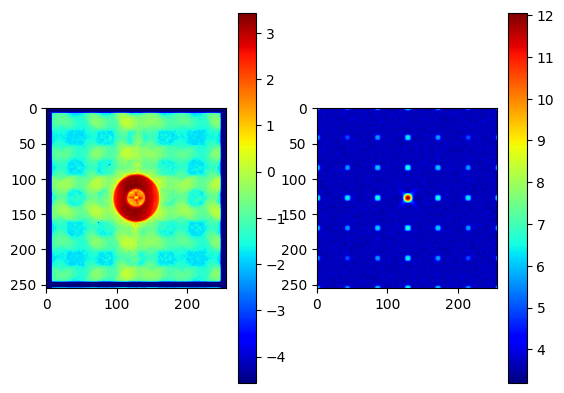

In [12]:
# separate amplitude and phase
# thus network used the amplitude of the intensity patterns
amp_conv = log10_custom(conv_DPs_shuff)
amp_ideal = log10_custom(ideal_DPs_shuff)
amp_probe = np.abs(probe_DPs_shuff)
phase_conv = np.angle(conv_DPs_shuff)
phase_ideal = np.angle(ideal_DPs_shuff)
phase_probe = np.angle(probe_DPs_shuff)


fig,ax=plt.subplots(1,2)
ri=random.randint(0,len(amp_conv))
im1=ax[0].imshow(amp_conv[ri])
im2=ax[1].imshow(amp_ideal[ri])
plt.colorbar(im1)
plt.colorbar(im2)
plt.show()

In [13]:
# resize data
if red:
    print("Resizing...")
    amp_ideal_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_ideal)])
    amp_conv_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_conv)])
    amp_probe_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_probe)])
else:
    print("No resizing...")
    amp_ideal_red=amp_ideal
    amp_conv_red=amp_conv
    amp_probe_red=amp_probe
print(f'maximum in ideal patterns: {np.max(amp_ideal_red[ri])}')
print(f'maximum in conv patterns: {np.max(amp_conv_red[ri])}')    

Resizing...


100%|██████████| 10/10 [00:00<00:00, 988.13it/s]

maximum in ideal patterns: 12.042504675312882
maximum in conv patterns: 3.4219254647050037


C:\Users\b304014\AppData\Local\Temp\ipykernel_148612\2302143922.py:16: RuntimeWarning: invalid value encountered in divide
  amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])


normalized maximum in ideal/output patterns: 1.0
normalized maximum in conv/input patterns: 1.0


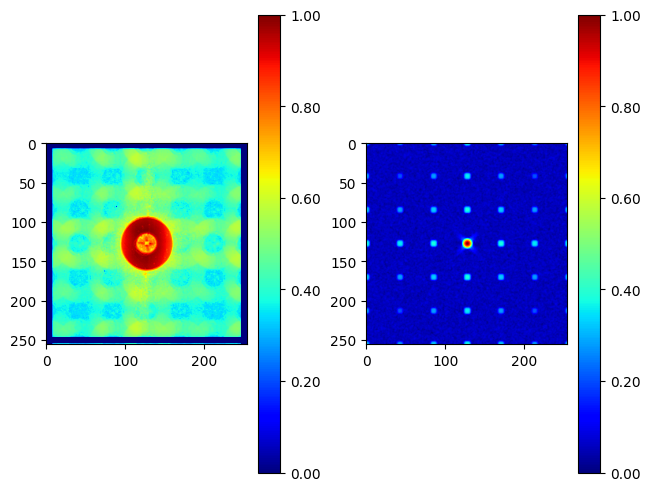

In [14]:
# Scale factors

#NORMALIZE OUTPUT FROM 0 to 1
ideal_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_ideal_red])
ideal_constants=np.asarray([(np.min(a)) for a in amp_ideal_red])
amp_ideal_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_ideal_red])

# #NORMALIZE INPUT FROM 0 to 1
conv_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_conv_red])
conv_constants=np.asarray([(np.min(a)) for a in amp_conv_red])
amp_conv_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_conv_red])

# #NORMALIZE INPUT FROM 0 to 1
probe_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_probe_red])
probe_constants=np.asarray([(np.min(a)) for a in amp_probe_red])
amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])

print(f'normalized maximum in ideal/output patterns: {np.max(amp_ideal_red[0])}')
print(f'normalized maximum in conv/input patterns: {np.max(amp_conv_red[0])}')

fig,ax=plt.subplots(1,2,layout='constrained')
im1=ax[1].imshow(amp_ideal_red[0])#,norm=colors.LogNorm())
plt.colorbar(im1, ax=ax[1], format='%.2f')
im2=ax[0].imshow(amp_conv_red[0])#,norm=colors.LogNorm())
plt.colorbar(im2, ax=ax[0], format='%.2f')
plt.show()

In [ ]:
save=False
if save:
    np.save(os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_numDPs{numDPs}.npz')),{'amp_conv_red':amp_conv_red,'amp_ideal_red':amp_ideal_red})